## MEG Group Analysis

Group analysis for MEG data. 

Data Sources:
- OMEGA Data Repository
- Human Connectome Project (HCP)

This notebook is for group analysis of MEG data using the om.meg codebase, in particular it is set up for oscillatory band analysis.

In [1]:
%matplotlib inline

from scipy.io import loadmat
from scipy.stats.stats import pearsonr

from om.meg.single import MegSubj
from om.meg.single import print_corrs_mat, print_corrs_vec
from om.meg.group import MegGroup
from om.meg.group import osc_space_group

from om.plts.meg import *

from om.core.db import OMDB
from om.core.osc import Osc
from om.core.io import load_obj_pickle, save_obj_pickle

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from om.meg.group import osc_space_group
from om.plts.meg import *

### Setup

In [4]:
# Get database object
db = OMDB()

In [5]:
# Check what data is available
#  Note: this function outa date (checks the wrong file folder)
sub_nums, source = db.check_dat_files(dat_type='fooof', dat_source='HCP', verbose=True)

# Drop outlier subject
sub_nums = list(set(sub_nums) - set([662551]))


Number of Subjects available: 81

Subject numbers with FOOOF data available: 
[162026, 153732, 172029, 175540, 825048, 187547, 102816, 512835, 174841, 109123, 164636, 660951, 352132, 250427, 100307, 166438, 221319, 917255, 111514, 158136, 214524, 706040, 283543, 106521, 156334, 559053, 198653, 181232, 212318, 205119, 725751, 581450, 255639, 248339, 195041, 293748, 665254, 191841, 116726, 667056, 352738, 891667, 212823, 140117, 353740, 287248, 898176, 715950, 105923, 185442, 990366, 877168, 154532, 233326, 601127, 599671, 189349, 204521, 679770, 406836, 257845, 112920, 735148, 568963, 116524, 113922, 912447, 162935, 358144, 707749, 223929, 192641, 191437, 814649, 175237, 783462, 555348, 191033, 146129, 662551, 433839]



### Oscillation Band Definitions

In [6]:
# Set up oscillation band definitions to use

# Default Bands
#osc = Osc(default=True)

# Custom bands
osc = Osc()
osc.add_band('Theta', [3, 7])
osc.add_band('Alpha', [7, 14])
osc.add_band('Beta', [15, 30])

In [7]:
# 'TheAlpha' used for spatial variation across the cortex
#osc.add_band('TheAlpha', [3, 14])

### Load Data

In [8]:
# Initialize MegGroup object
meg_group = MegGroup(db, osc)

# Add subjects to meg_group
for i, subj in enumerate(sub_nums):
    meg_subj = MegSubj(OMDB(), source[i], osc)         # Initialize MegSubj object
    meg_subj.import_fooof(subj, get_demo=True)         # Import subject data
    meg_subj.all_oscs(verbose=False)                   # Create vectors of all oscillations
    meg_subj.osc_bands_vertex()                        # Get oscillations per band per vertex
    meg_subj.peak_freq(dat='all', avg='mean')       # Calculate peak frequencies
    meg_group.add_subject(meg_subj,                    # Add subject data to group object
                          add_all_oscs=True,               # Whether to include all-osc data
                          add_vertex_bands=True,           # Whether to include osc-band-vertex data
                          add_peak_freqs=True,             # Whether to include peak frequency data
                          add_vertex_oscs=False,           # Whether to include all-osc data for each vertex
                          add_vertex_exponents=True,       # Whether to include the aperiodic exponent per vertex
                          add_demo=True)                   # Whether to include demographic information

In [9]:
# OR: Check available saved files to load one of them
meg_files = db.check_res_files('meg')


Number of files available: 0

Files available: 




In [10]:
# Load a pickled file
#meg_group = load_obj_pickle('meg', meg_files[2])

### Data Explorations

In [11]:
# Check how many subjects group includes
print('Currently analyzing ' + str(meg_group.n_subjs) + ' subjects.')

Currently analyzing 80 subjects.


In [12]:
# Check some simple descriptives
print('Number of oscillations found across the whole group: ', meg_group.n_oscs_tot)
print('Average number of oscillations per vertex: ', np.mean(meg_group.n_oscs / 7501))

Number of oscillations found across the whole group:  2499704
Average number of oscillations per vertex:  4.1656179176109855


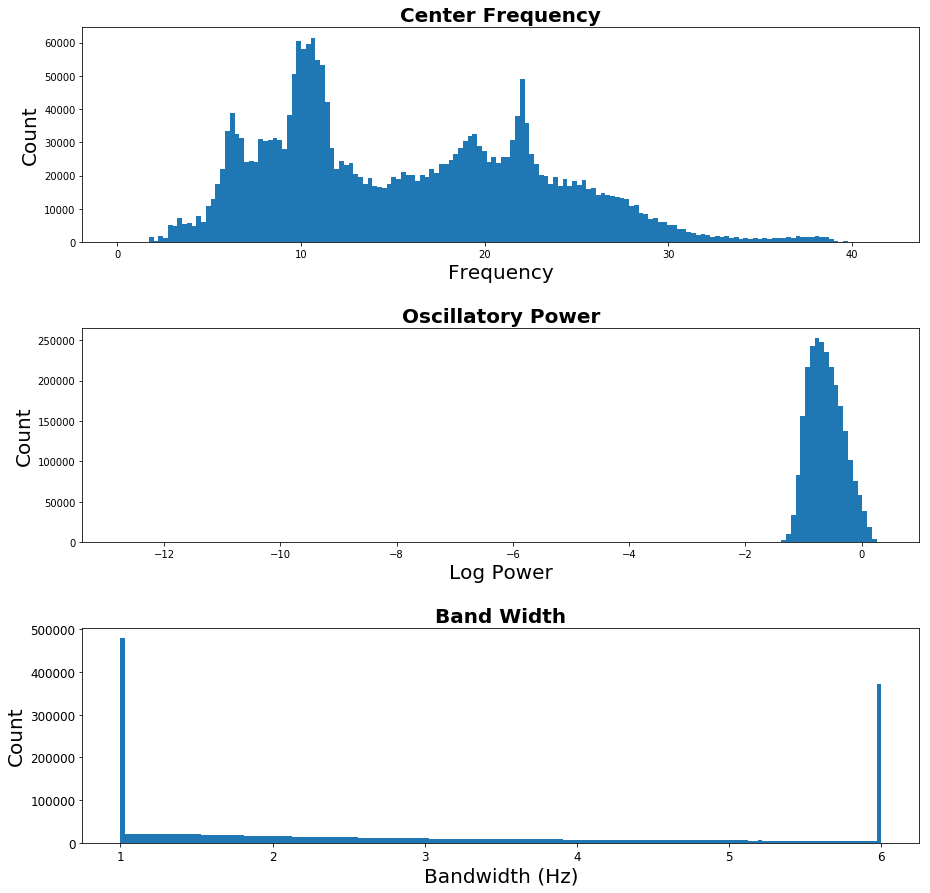

In [13]:
# Plot all oscillations across the group
plot_all_oscs(meg_group.centers_all, meg_group.powers_all, meg_group.bws_all, meg_group.comment, save_out=False)

### Save out probabilities per frequency range

In [14]:
# Check for oscillations above / below fitting range
#   Note: this is a quirk of older FOOOF version - fixed in fitting now
print(len(meg_group.centers_all[meg_group.centers_all < 2]))
print(len(meg_group.centers_all[meg_group.centers_all > 40]))

1698
130


In [15]:
# Calculate probability of observing an oscillation in each frequency
bins = np.arange(0, 43, 1)
counts, freqs = np.histogram(meg_group.centers_all, bins=bins)
probs = counts / meg_group.n_oscs_tot

In [16]:
# Fix for the oscillation out of range
add = sum(probs[0:3]) + sum(probs[35:])

freqs = freqs[3:35]
probs = probs[3:35]
probs = probs + (add/len(probs))

In [17]:
# np.save('freqs.npy', freqs)
# np.save('probs.npy', probs)

### ???

In [18]:
b1 = meg_group.bws_all > 1.1
b2 = meg_group.bws_all < 5

In [19]:
#ee = meg_group.centers_all[ and ]

In [20]:
np.max(meg_group.bws_all)

5.999999999999999

In [21]:
sum(meg_group.bws_all < 1.1)

526446

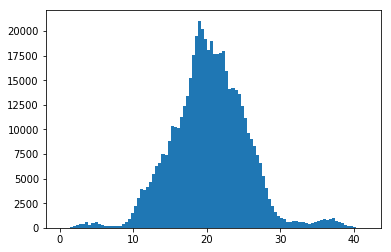

In [22]:
plt.hist(meg_group.centers_all[meg_group.bws_all > 5], 100);

In [23]:
#
ee = meg_group.centers_all[meg_group.centers_all < 3]
ff = meg_group.centers_all[meg_group.centers_all > 35]

meg_group.centers_all[meg_group.centers_all < 3] = 0
meg_group.centers_all[meg_group.centers_all > 35] = 0

In [24]:
print(sum(meg_group.centers_all < 0))
print(sum(meg_group.centers_all > 35))

0
0


In [25]:
print(len(ee))
print(len(ff))

print((len(ee) + len(ff)) / meg_group.n_oscs_tot)

9537
21809
0.012539884722351126


In [26]:
bin_size = 1
bins = np.arange(3, 35+bin_size, bin_size)

In [27]:
counts, _ = np.histogram(meg_group.centers_all, bins)
rats = counts / (meg_group.n_oscs_tot - (len(ee) + len(ff)))

In [28]:
#binds = (meg_group.centers_all > 10.) & (meg_group.centers_all < 10.5)
#np.mean(meg_group.powers_all[binds])

In [29]:
# ??
pows = []
bws = []
avg_pows = []; std_pows = []
avg_bws = []; std_bws = []
for lb, ub in zip(bins[:-1], bins[1:]):
    binds = (meg_group.centers_all > lb) & (meg_group.centers_all < ub)
    
    pows.append(meg_group.powers_all[binds])
    bws.append(meg_group.bws_all[binds])
    
    avg_pows.append(np.mean(meg_group.powers_all[binds]))
    std_pows.append(np.std(meg_group.powers_all[binds]))
    avg_bws.append(np.mean(meg_group.bws_all[binds]))
    std_bws.append(np.std(meg_group.bws_all[binds]))
    

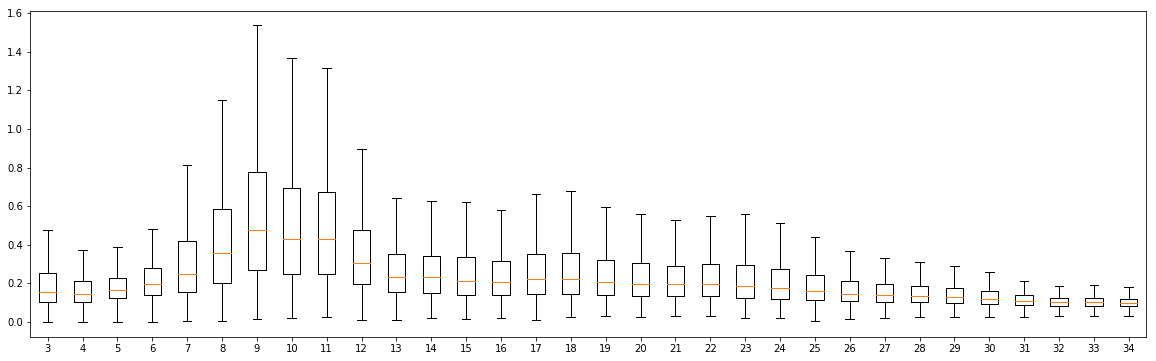

In [30]:
plt.figure(figsize=[20, 6])
plt.boxplot(pows, labels=bins[:-1], showfliers=False);

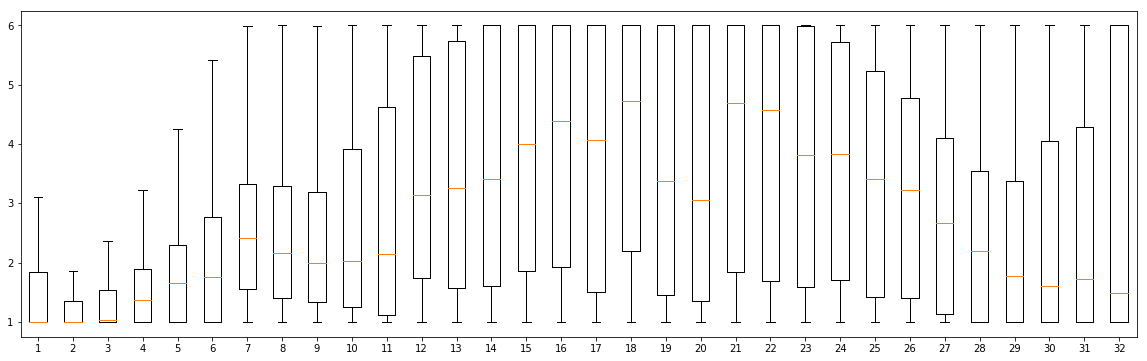

In [31]:
plt.figure(figsize=[20, 6])
plt.boxplot(bws, showfliers=False);

In [32]:
print(len(bins))
print(len(avg_bws))

33
32


In [33]:
#np.save('freqs', bins[])
#np.save('rats', rats)

In [34]:
sum(rats)

1.0000000000000002

<BarContainer object of 32 artists>

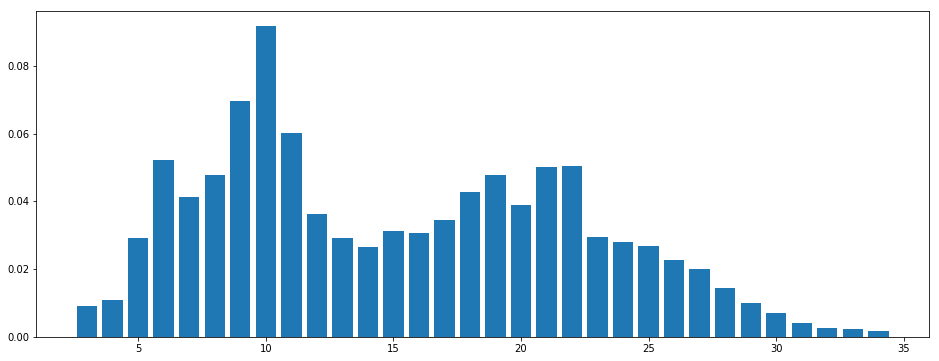

In [35]:
plt.figure(figsize=[16, 6])
plt.bar(bins[:-1], rats)

<ErrorbarContainer object of 3 artists>

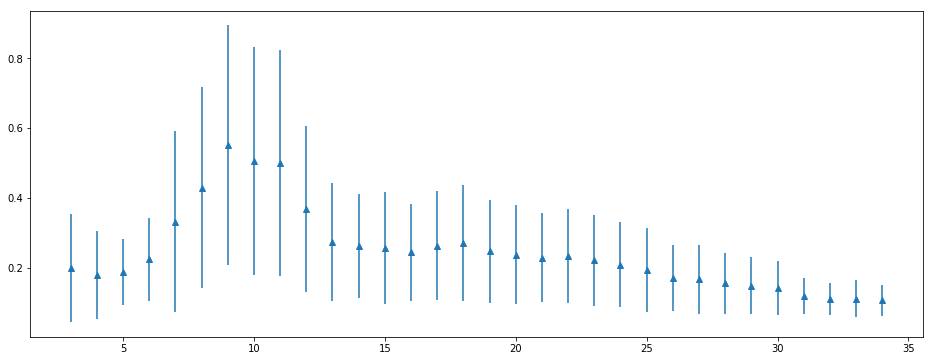

In [36]:
plt.figure(figsize=[16, 6])
plt.errorbar(bins[:-1], avg_pows, std_pows, linestyle='None', marker='^')
#plt.plot(bins[:-1], avg_pows, '.')
#plt.bar(bins[:-1], avg_pows)

<ErrorbarContainer object of 3 artists>

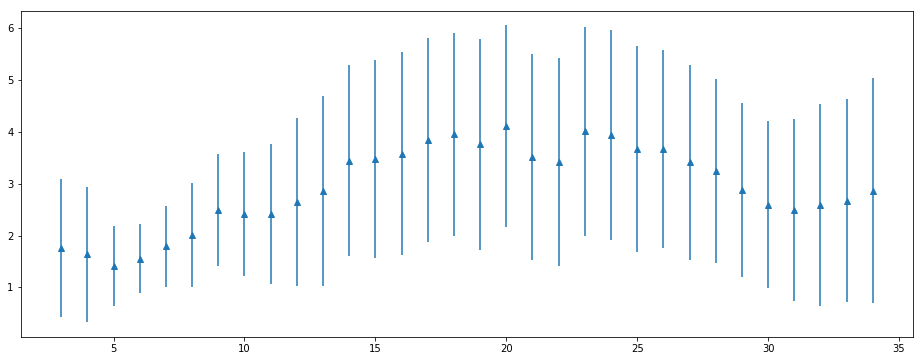

In [37]:
plt.figure(figsize=[16, 6])
plt.errorbar(bins[:-1], avg_bws, std_bws, linestyle='None', marker='^')
#plt.plot(bins[:-1], avg_bws, '.')
#plt.bar(bins[:-1], avg_bws)

## BACK TO NORMAL PROGRAMMING

In [38]:
# ??
print(sum(meg_group.powers_all < 0.05) / len(meg_group.powers_all))
print(sum(meg_group.bws_all < 1.0001) / len(meg_group.bws_all))

0.002132252458691109
0.18261122116858636


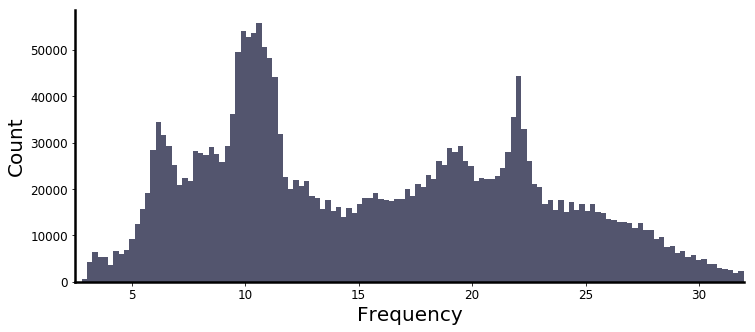

In [39]:
# Plot a single oscillation parameter at a time
#plt_dat = meg_group.powers_all[meg_group.powers_all > 0.01]
#plot_all_oscs_single(plt_dat, 1, meg_group.comment, n_bins=120, size=(15, 5), save_out=False)

plot_all_oscs_single(meg_group.centers_all, 0, meg_group.comment, n_bins=150, size=(12, 5), save_out=True)

#plot_all_oscs_single(meg_group.powers_all, 1, meg_group.comment, n_bins=150, size=(12, 5), save_out=True)
#plot_all_oscs_single(meg_group.bws_all, 2, meg_group.comment, n_bins=150, size=(12, 5), save_out=True)

In [40]:
# Calculate correlations between oscillatory parameters
gr_rs_mat, gr_ps_mat, param_labels = meg_group.calc_osc_param_corrs()
print_corrs_mat(gr_rs_mat, gr_ps_mat, param_labels)

Corr of  Centers-Powers      is  -0.2770     with p-val of  0.00000
Corr of  Centers-Bandwidths  is  +0.3060     with p-val of  0.00000
Corr of  Powers-Bandwidths   is  +0.0841     with p-val of  0.00000


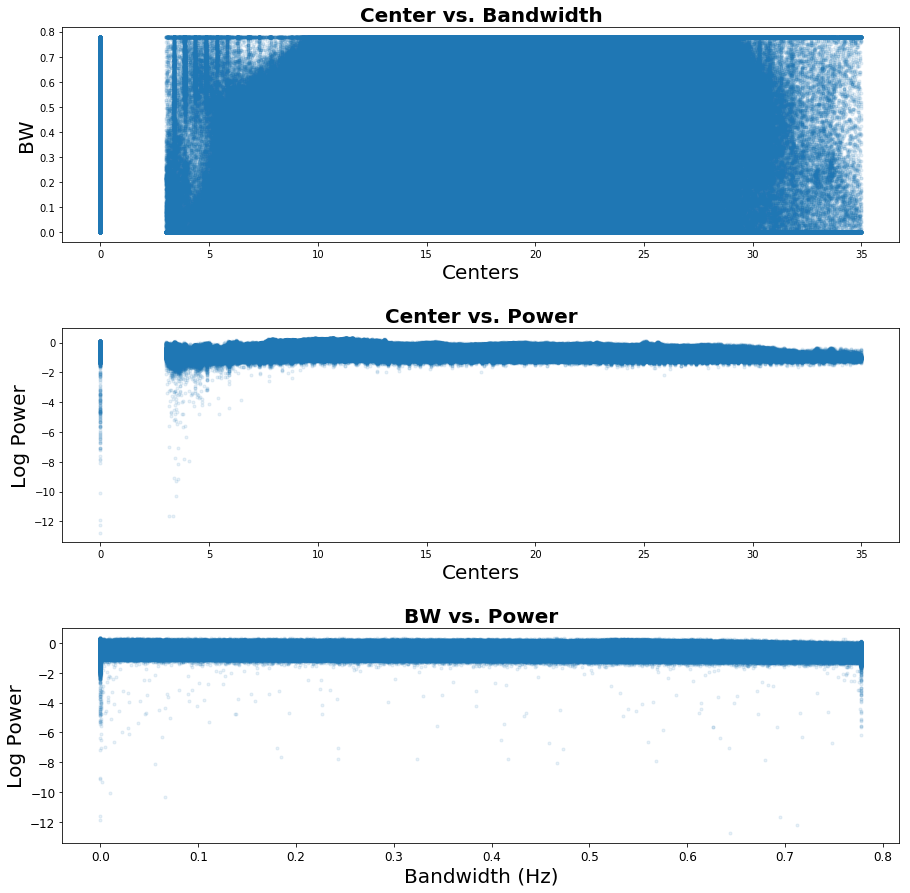

In [41]:
# Plot the comparisons between oscillatory parameters
plot_osc_param_comparison(meg_group.centers_all, meg_group.powers_all, meg_group.bws_all,
                          meg_group.comment)

In [42]:
# Within band comparison of oscillation features

#band = 'TheAlpha'

for band in ['Theta', 'Alpha', 'Beta']:
    corrs = [[], [], []]
    for ind, comp in enumerate(((0, 1), (0, 2), (1, 2))):
        for si in range(meg_group.n_subjs):
            r, p = pearsonr(meg_group.gr_oscs[band][:, comp[0], si],
                            meg_group.gr_oscs[band][:, comp[1], si])
            corrs[ind].append(r)
    corrs = np.array(corrs)
    print(band)
    print('\tCF-Pow\tCF-BW\tPow-BW')
    print('\t{:1.2f}\t{:1.2f}\t{:1.2f}'.format(*np.mean(corrs, 1)))

Theta
	CF-Pow	CF-BW	Pow-BW
	0.85	0.85	0.74
Alpha
	CF-Pow	CF-BW	Pow-BW
	0.38	0.37	0.23
Beta
	CF-Pow	CF-BW	Pow-BW
	0.28	0.32	0.36


### Exponents

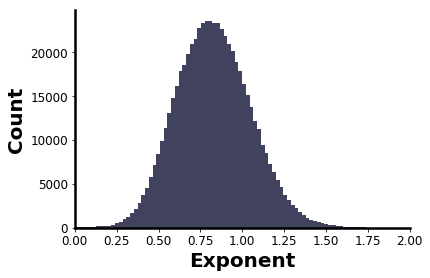

In [43]:
# Plot distribution of all aperiodic exponents
plot_exponents(meg_group.exponents, meg_group.comment, save_out=False)

In [44]:
# Calculate Average Aperiodic Exponent value per Vertex
meg_group.group_exponent(avg='mean')

In [45]:
# Save out group exponent results
#meg_group.save_gr_exponent(file_name='json')

In [46]:
# Set group exponent results for visualization with Brainstorm
#meg_group.set_exponent_viz()

### Oscillation Topographies

##### Oscillation Probability

In [47]:
# Calculate probability of oscilation (band specific) across the cortex
meg_group.osc_prob()

In [48]:
# Correlations between probabilities of oscillatory bands. 
prob_rs, prob_ps, prob_labels = meg_group.osc_map_corrs(map_type='prob')
print_corrs_mat(prob_rs, prob_ps, prob_labels)

Corr of  Theta-Alpha         is  -0.6736     with p-val of  0.00000
Corr of  Theta-Beta          is  -0.3084     with p-val of  0.00000
Corr of  Alpha-Beta          is  +0.2005     with p-val of  0.00000


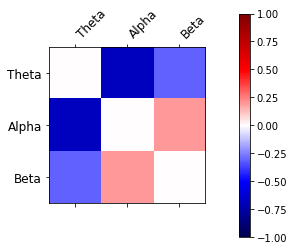

In [49]:
# Plot the oscillation probability correlation matrix
plot_corr_matrix(prob_rs, osc.labels, save_out=False)

In [50]:
# Save group oscillation probability data for visualization with Brainstorm
meg_group.set_map_viz(map_type='prob', file_name='json')

In [51]:
# Save group oscillation probability data out to npz file
#meg_group.save_map(map_type='prob', file_name='json')

##### Oscillation Power Ratio

In [52]:
# Calculate power ratio of oscilation (band specific) across the cortex
meg_group.osc_power()

In [53]:
# Correlations between probabilities of oscillatory bands. 
power_rs, power_ps, power_labels = meg_group.osc_map_corrs(map_type='power')
print_corrs_mat(power_rs, power_ps, power_labels)

Corr of  Theta-Alpha         is  -0.5050     with p-val of  0.00000
Corr of  Theta-Beta          is  -0.4081     with p-val of  0.00000
Corr of  Alpha-Beta          is  +0.7794     with p-val of  0.00000


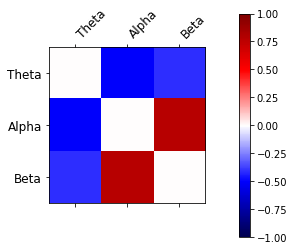

In [54]:
# Plot the oscillation probability correlation matrix
plot_corr_matrix(power_rs, osc.labels, save_out=True)

In [55]:
# Save group oscillation probability data for visualization with Brainstorm
meg_group.set_map_viz(map_type='power', file_name='json')

In [56]:
# Save group oscillation probability data out to npz file
#meg_group.save_map(map_type='power', file_name='json')

##### Oscillation Score

In [57]:
# Calculate oscillation score
meg_group.osc_score()

In [58]:
# Save group oscillation probability data for visualization with Brainstorm
#meg_group.set_map_viz(map_type='score', file_name='json')

In [59]:
# Save group oscillation score data out to npz file
meg_group.save_map(map_type='score', file_name='80_new_group')

In [60]:
# Correlations between osc-scores of oscillatory bands.
score_rs, score_ps, score_labels = meg_group.osc_map_corrs(map_type='score')
print_corrs_mat(score_rs, score_ps, score_labels)

Corr of  Theta-Alpha         is  -0.5971     with p-val of  0.00000
Corr of  Theta-Beta          is  -0.4088     with p-val of  0.00000
Corr of  Alpha-Beta          is  +0.7214     with p-val of  0.00000


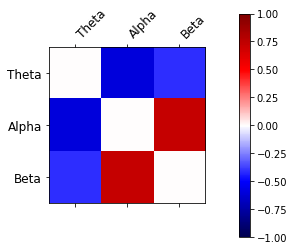

In [61]:
# Plot the oscillation score correlation matrix
plot_corr_matrix(score_rs, osc.labels, save_out=True)

In [62]:
# Save out pickle file of current MegGroup() object
#save_obj_pickle(meg_group, 'meg', 'test')

#### Check correlation of aperiodic exponent with oscillation bands

In [67]:
n_bands = len(meg_group.bands)
exp_rs = np.zeros(shape=[n_bands])
for ind, band in enumerate(meg_group.bands):
    r_val, p_val = pearsonr(meg_group.exponent_gr_avg, meg_group.osc_scores[band])
    exp_rs[ind] = r_val
    #print(band)
    #print('\t', pearsonr(meg_group.exponent_gr_avg, meg_group.osc_scores[band]))
    #print('\t', pearsonr(meg_group.exponent_gr_avg, meg_group.osc_probs[band]))

In [69]:
exp_rs

array([-0.29689132,  0.83026359,  0.54374924])

#### Plot corr matrix including bands & exponents

In [70]:
all_rs = np.zeros(shape=[n_bands+1, n_bands+1])
all_rs[0:n_bands, 0:n_bands] = score_rs

all_rs[n_bands, 0:n_bands] = exp_rs
all_rs[0:n_bands, n_bands] = exp_rs;

from copy import deepcopy
all_labels = deepcopy(osc.labels)
all_labels.append('Exps')

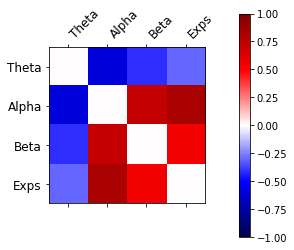

In [71]:
plot_corr_matrix(all_rs, all_labels, save_out=False)

## Individual Variation

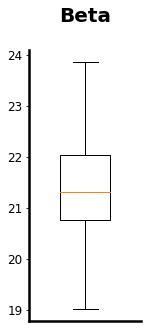

In [72]:
# Plots for single peak frequency boxplot
band = 'Beta'
plot_peak_boxplot(meg_group.peaks[band], band, save_out=False)

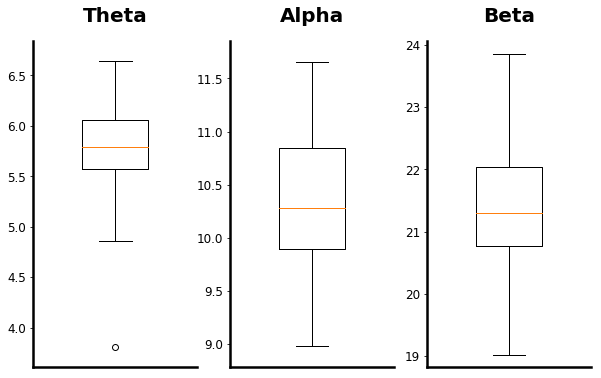

In [73]:
# Plot the peak frequency boxplots for all oscillation bands
plot_peak_boxplot_all(meg_group.peaks, meg_group.bands, save_out=False)

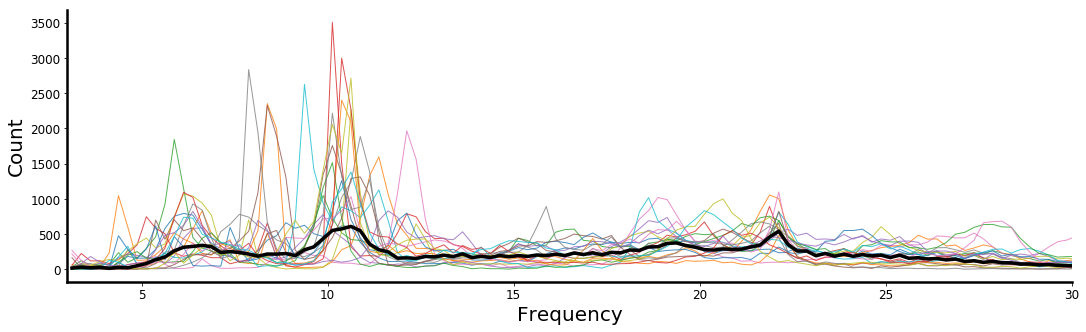

In [74]:
# Plot the individual oscillation profiles figure
plot_osc_profiles(meg_group.centers_hist, 20, save_out=True)

## Demographics

Demographic information with the MEG databases:

- OMEGA: At a minimum, for each subject we have birth year, giving us approximate age, and sex. 

- HCP: For each subject, we have birth year, sex, and many other demographic variables. 

In [75]:
# Check demographics
print('Ages range from ', min(meg_group.age), ' to ', max(meg_group.age), 
      ' with an average of ', np.mean(meg_group.age))

Ages range from  22.0  to  35.0  with an average of  28.7125


In [76]:
# Check correlations between age and peak frequency within oscillation bands
age_peak_rs, age_peak_ps, labels = meg_group.calc_osc_peak_age()
print_corrs_vec(age_peak_rs, age_peak_ps, labels, 'Age')

Corr of  Theta-Age             is  -0.1883     with p-val of  0.09445
Corr of  Alpha-Age             is  -0.0904     with p-val of  0.42501
Corr of  Beta-Age              is  +0.2085     with p-val of  0.06340


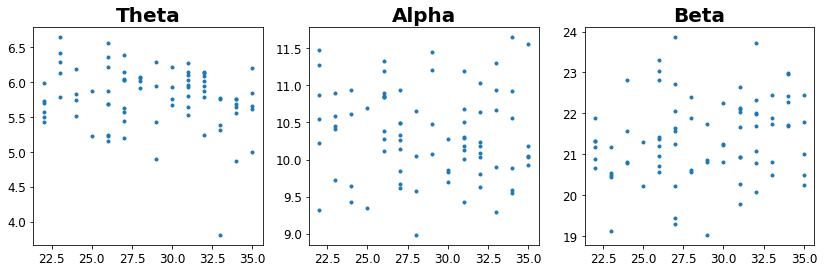

In [77]:
# Plot comparisons between age and oscillation peaks
plot_age_peak(meg_group.age,
              meg_group.peaks['Theta'],
              meg_group.peaks['Alpha'], 
              meg_group.peaks['Beta'],
              save_out=False)

In [78]:
# Check for correlation between number of oscillations found and age.
[r_age_nOsc, p_age_nOsc] = pearsonr(meg_group.age, meg_group.n_oscs)
print('Corr of # Oscillations / Age is ', '{:+1.4f}'.format(r_age_nOsc), 
          ' with p-val of ', '{:1.5f}'.format(p_age_nOsc), '\n')

Corr of # Oscillations / Age is  -0.0193  with p-val of  0.86512 



In [80]:
# Aperiodic Exponent - get global average exponent
exps = np.mean(meg_group.vert_exponents, 0)

In [83]:
# Check for correlation between global average exponent and age
r_val, p_val = pearsonr(meg_group.age, exps)
print(r_val, p_val)

-0.463041276798934 1.525931163978805e-05


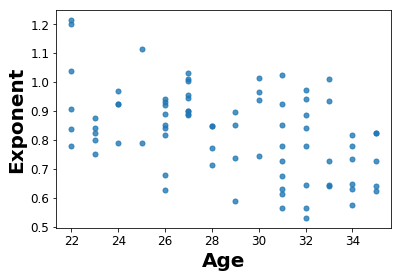

In [84]:
# Scatter plot comparing age and number of oscillations
plot_scatter(meg_group.age, exps, ['Age', 'Exponent'], title='ExponentAge', save_out=False)

In [85]:
# Run exponent correlation across every vertex
exp_corrs = np.zeros([7501, 2])
for ind, dat in enumerate(meg_group.vert_exponents):
    exp_corrs[ind, :] = pearsonr(meg_group.age, dat)

In [87]:
# Hack to seve out the exponent-age corr by vertex map for visualization
#meg_group.exponent_gr_avg = exp_corrs[:, 0]
#meg_group.set_exponent_viz()

## Spatial Analysis

### Compare Oscillation & BG Parameters Across the Cortex

Exploring how background and oscillations vary spatially across the cortex. 

The loaded vertex data `verts` is a 2D matrix of the form [n_vertices, n_dims] in which the columns indices are:
- 0: posterior -> anterior position
- 1: left -> right position
- 2: bottom -> top position

In [88]:
# Set path & name for loading vertex data
vert_path = '/Users/tom/Documents/Research/1-Projects/MEGmapping/vertices.mat'
label = 'vertices'

# Load and extract vertex data
vert_dat = loadmat(vert_path)
verts = np.array(vert_dat[label])

### Exponent - Spatial Topography

In [89]:
# Spatial drift of group aperiodic exponent across the cortex [group exponent maps]
print('{} \t {}'.format(*pearsonr(meg_group.exponent_gr_avg, verts[:, 0])))
print('{} \t {}'.format(*pearsonr(meg_group.exponent_gr_avg, verts[:, 1])))
print('{} \t {}'.format(*pearsonr(meg_group.exponent_gr_avg, verts[:, 2])))

0.3351590922556601 	 2.5404396460322495e-196
0.19036678925488348 	 3.762766952529587e-62
-0.5668460086682807 	 0.0


In [90]:
# Run correlation of exponent values with position within each subject
ind_exp_corrs = [pearsonr(exps, verts[:, 0])[0] for exps in meg_group.vert_exponents.T]

In [91]:
# Check average correlation values
print(np.median(ind_exp_corrs))

-0.5330438578554816


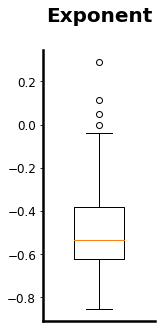

In [93]:
# Boxplot - distribution of exponent/space correlations
plot_peak_boxplot(ind_exp_corrs, 'Exponent', save_out=True)

### Oscillation Map Topographies - Correlations Across Space

In [94]:
# Oscillation probability maps
for band in osc.labels:
    print(band, '\t{}\t{}'.format(*pearsonr(meg_group.osc_probs[band], verts[:, 0])))

Theta 	0.5993800392214715	0.0
Alpha 	-0.8103053455400265	0.0
Beta 	-0.3932697431584287	5.910491080918947e-276


In [95]:
# Oscillation power ratio maps
for band in osc.labels:
    print(band, '\t{}\t{}'.format(*pearsonr(meg_group.osc_pow_ratios[band], verts[:, 0])))

Theta 	0.3775365015118889	9.64443447011176e-253
Alpha 	-0.9347851533806038	0.0
Beta 	-0.6608559635272747	0.0


In [96]:
# Oscillation score maps
for band in osc.labels:
    print(band, '\t{}\t{}'.format(*pearsonr(meg_group.osc_scores[band], verts[:, 0])))

Theta 	0.4669107309456656	0.0
Alpha 	-0.9373857041819165	0.0
Beta 	-0.6276034102357005	0.0


### Individual Subject Level

In [97]:
# Calculate oscillation space correlations, per subject
osc_space_corrs, labels = osc_space_group(meg_group.gr_oscs, meg_group.bands,
                                          verts, osc_param=0, space_param=0)

In [98]:
#
print(np.mean(osc_space_corrs[:, :, 0], axis=0))
print(np.median(osc_space_corrs[:, :, 0], axis=0))

[-0.11802325 -0.17593329  0.40178322]
[-0.12285791 -0.17864557  0.41389598]


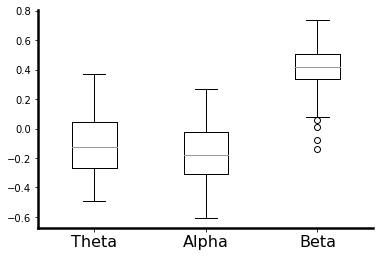

In [99]:
# Plot space corrs
plot_osc_space_corr_boxplot(osc_space_corrs, labels, save_out=False)

In [100]:
def plot_space_comp_all(oscs, bands, verts, osc_param=0, space_param=1):
    """   """
    
    # 
    space = verts[:, space_param]
    sort_inds = np.argsort(space)

    # Initialize plot
    f, ax = plt.subplots(2, 2)
    
    for i, band in enumerate(bands):
        
        freqs = [dat if dat > 0 else None for dat in oscs[band][sort_inds, osc_param, subj]]
        
        ax[0, 0].plot(space, freqs, '.', ms=3.5, alpha=0.75)
        
        ax[0, 0].set_xlim([space.min(), space.max()])
        
        #ax[].set_title(band, {'fontsize': t_fs, 'fontweight': 'bold'})

        #
        #ax[].xlabel('Posterior -> Anterior', {'fontsize': ax_fs, 'fontweight': 'bold'})
        #ax[].ylabel('Center Frequency', {'fontsize': ax_fs, 'fontweight': 'bold'})

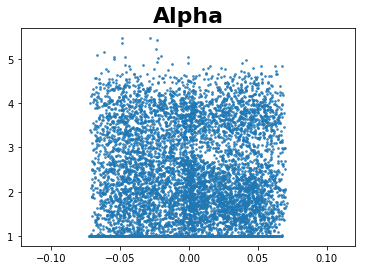

In [101]:
#
#plot_space_comp(meg_group.gr_oscs, verts, 'TheAlpha', 40)
#plot_space_comp(meg_group.gr_oscs, verts, 'Theta', 50)
plot_space_comp(meg_group.gr_oscs, verts, 'Alpha', 8, 2)
#plot_space_comp(meg_group.gr_oscs, verts, 'Beta', 0, 2)

In [102]:
# Get the indices to sort the vertex matrix into order, by particular directions
ant_pos_sort_inds = np.argsort(verts[:, 0])
lef_rig_sort_inds = np.argsort(verts[:, 1])
top_bot_sort_inds = np.argsort(verts[:, 2])

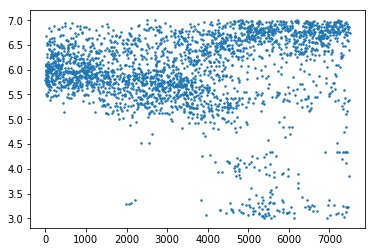

In [103]:
subj = 20
plt_dat = [dat if dat > 0 else np.nan for dat in meg_group.gr_oscs['Theta'][ant_pos_sort_inds, 0, subj]]
plt.plot(plt_dat, '.', ms=3)
#plt.xlabel('Posterior -> Anterior')
#plt.ylabel('Center Frequency')

### Center Frequency Topographical Variation

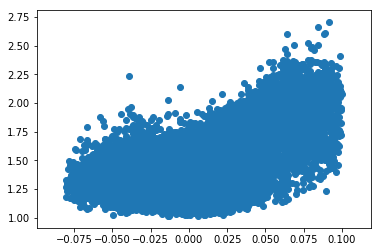

In [106]:
theta_cf = np.copy(meg_group.gr_oscs['Theta'][:, 2, :])
theta_cf[theta_cf == 0] = np.nan

plt.scatter(verts[:, 0], np.nanmean(theta_cf, 1))
pearsonr(verts[:, 0], np.nanmean(theta_cf, 1))

meg_group.osc_scores['Theta'] = np.nanmean(theta_cf, 1)

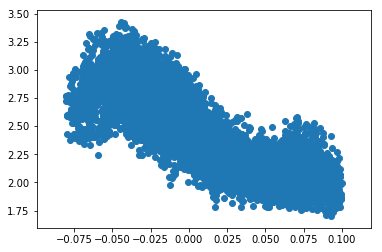

In [107]:
alpha_cf = np.copy(meg_group.gr_oscs['Alpha'][:, 2, :])
alpha_cf[alpha_cf == 0] = np.nan

plt.scatter(verts[:, 0], np.nanmean(alpha_cf, 1))
pearsonr(verts[:, 0], np.nanmean(alpha_cf, 1))

meg_group.osc_scores['Alpha'] = np.nanmean(alpha_cf, 1)

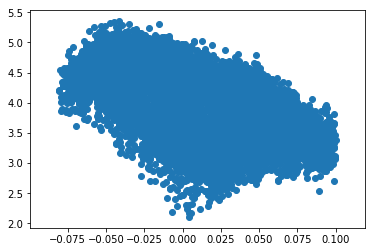

In [108]:
beta_cf = np.copy(meg_group.gr_oscs['Beta'][:, 2, :])
beta_cf[beta_cf == 0] = np.nan

plt.scatter(verts[:, 0], np.nanmean(beta_cf, 1))
pearsonr(verts[:, 0], np.nanmean(beta_cf, 1))

meg_group.osc_scores['Beta'] = np.nanmean(beta_cf, 1)

In [110]:
#meg_group.osc_score_done = True
#meg_group.set_map_viz('score', 'BW')

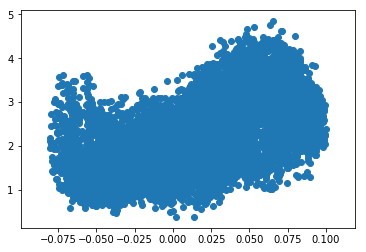

In [111]:
plt.scatter(verts[:, 0], np.mean(meg_group.gr_oscs['Theta'][:, 0, :], 1))

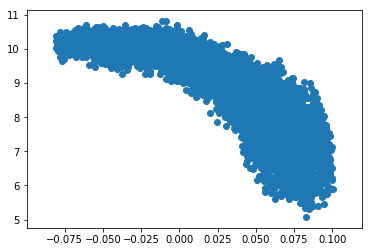

In [112]:
plt.scatter(verts[:, 0], np.mean(meg_group.gr_oscs['Alpha'][:, 0, :], 1))

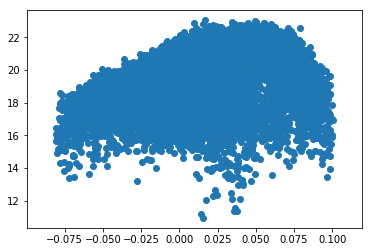

In [113]:
plt.scatter(verts[:, 0], np.mean(meg_group.gr_oscs['Beta'][:, 0, :], 1))